In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

import polars as pl
from pathlib import Path

In [30]:
first_task = pd.read_csv("ELEC 343 Lab 1 - 1B.csv", skiprows=1)
first_task["plunger position (mm)"] = (first_task["plunger position (mm)"] - first_task["plunger position (mm)"][0])/100 
first_task.head()

,Measurement,plunger position (mm),Unnamed: 2,inductance (mH),Z,R
0,1,0.00,0.0,673.6,37.201,NaN
1,2,0.25,25.0,623.6,36.995,25.24
2,3,0.50,50.0,624.5,37.011,NaN
3,4,0.75,75.0,616.9,36.868,NaN
4,5,1.00,100.0,575.8,35.971,NaN


Fitted parameters:
  k1 = 1201.33918
  k2 = 1.62808
  L0 (from data) = 28.37000
Standard Errors:
  k1 std = 98.39235
  k2 std = 0.19228
R^2 = 0.93471


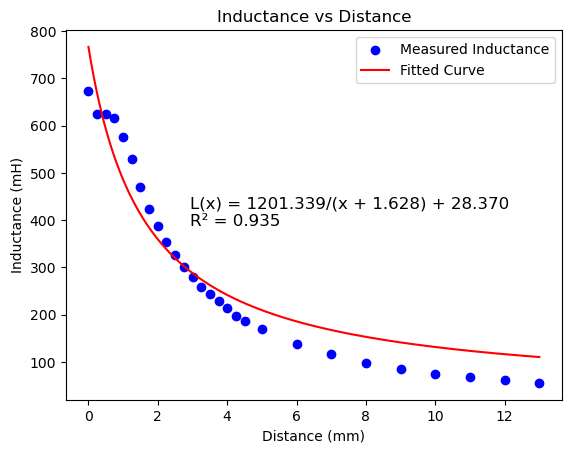

In [31]:
from scipy.optimize import curve_fit

x_data = first_task["plunger position (mm)"][:-1].values
y_data = first_task["inductance (mH)"][:-1].values

# 2. Get L0 from the last row of the DataFrame
L0 = first_task["inductance (mH)"].iloc[-1]

# 3. Define the inductance model: L(x) = k1 / (k2 + x) + L0
def inductance_model(x, k1, k2):
    return k1 / (k2 + x) + L0

# 4. Fit with initial guesses p0
p0 = [1.0, 1.0]
popt, pcov = curve_fit(inductance_model, x_data, y_data, p0=p0)
k1_fit, k2_fit = popt

# 5. Print fitted parameters
print("Fitted parameters:")
print(f"  k1 = {k1_fit:.5f}")
print(f"  k2 = {k2_fit:.5f}")
print(f"  L0 (from data) = {L0:.5f}")

# 6. Compute standard errors
std_errors = np.sqrt(np.diag(pcov))
std_k1, std_k2 = std_errors
print("Standard Errors:")
print(f"  k1 std = {std_k1:.5f}")
print(f"  k2 std = {std_k2:.5f}")

# 7. Evaluate the model on the original x_data for R²
y_pred = inductance_model(x_data, k1_fit, k2_fit)

# Calculate R²
ss_res = np.sum((y_data - y_pred)**2)             # residual sum of squares
ss_tot = np.sum((y_data - np.mean(y_data))**2)    # total sum of squares
r2 = 1 - (ss_res / ss_tot)

print(f"R^2 = {r2:.5f}")

# 8. Plot the data
plt.scatter(x_data, y_data, label="Measured Inductance", color="blue")

# 9. Generate a smooth fitted curve for plotting
x_fit = np.linspace(min(x_data), max(x_data), 200)
y_fit = inductance_model(x_fit, k1_fit, k2_fit)
plt.plot(x_fit, y_fit, label="Fitted Curve", color="red")

# 10. Display the equation and R² on the plot
# We'll show it in the form L(x) = k1/(k2 + x) + L0
# with numeric values for k1, k2, and L0. Adjust formatting as you like.
model_text = (
    f"L(x) = {k1_fit:.3f}/(x + {k2_fit:.3f}) + {L0:.3f}\n"
    f"R² = {r2:.3f}"
)
plt.text(
    0.25, 0.55, 
    model_text, 
    transform=plt.gca().transAxes, 
    fontsize=12, 
    verticalalignment='top'
)

# 11. Label and show
plt.title("Inductance vs Distance")
plt.xlabel("Distance (mm)")
plt.ylabel("Inductance (mH)")
plt.legend()
plt.savefig("Inductance vs distance.png", dpi=500)
plt.show()

In [17]:
ab = pd.read_csv("ELEC 343 Lab 1 - 2AB.csv")
filtered = ab[0:4]
filtered

,measurement,"weight mass, m (g)",voltage,averaged conversion coefficient,Unnamed: 4,Unnamed: 5,recorded voltage,force
0,1,20.0,0.037,NaN,NaN,NaN,NaN,NaN
1,2,220.0,0.139,NaN,NaN,NaN,NaN,NaN
2,3,1020.0,0.567,NaN,NaN,NaN,NaN,NaN
3,4,1220.0,0.701,NaN,NaN,NaN,NaN,NaN


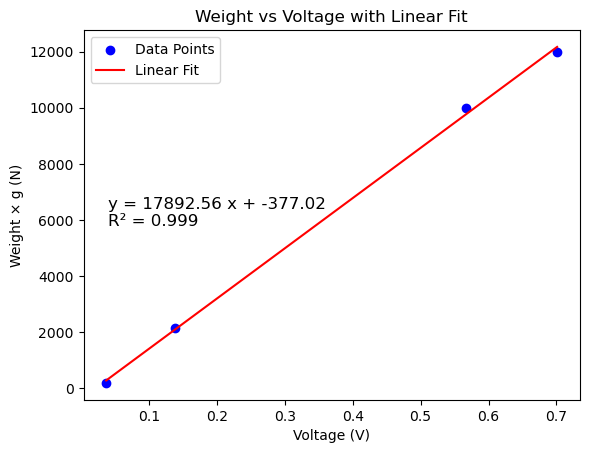

Slope = 17892.5635
Intercept = -377.0154
R^2 = 0.9989


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Example Data
# x: Voltage
# y: Weight mass (g) * g (9.81) = Force in Newtons
x = filtered["voltage"].values
y = filtered["weight mass, m (g)"].values * 9.81

# 1. Linear fit using polyfit (degree = 1)
slope, intercept = np.polyfit(x, y, 1)

# 2. Predict y values
y_pred = slope * x + intercept

# 3. Compute R²
r2 = r2_score(y, y_pred)

# 4. Plot the data as scatter
plt.scatter(x, y, label="Data Points", color="blue")

# Sort x for a nice line
x_sorted = np.sort(x)
y_fit = slope * x_sorted + intercept

# 5. Plot the fitted line
plt.plot(x_sorted, y_fit, label="Linear Fit", color="red")

# 6. Display the equation and R² on the plot
eq_text = f"y = {slope:.2f} x + {intercept:.2f}\nR² = {r2:.3f}"
plt.text(
    0.05,      # x-position in figure coordinates (0=left, 1=right)
    0.55,      # y-position in figure coordinates (0=bottom, 1=top)
    eq_text,
    transform=plt.gca().transAxes,  # Place text relative to axes
    fontsize=12,
    verticalalignment='top'         # Align text at the top
)

# Labels and legend
plt.xlabel("Voltage (V)")
plt.ylabel("Weight × g (N)")
plt.title("Weight vs Voltage with Linear Fit")
plt.legend()
plt.savefig("Force calibration.png", dpi=500)
plt.show()

# Print to console if desired
print(f"Slope = {slope:.4f}")
print(f"Intercept = {intercept:.4f}")
print(f"R^2 = {r2:.4f}")

In [70]:
conversion_coefficient = slope / 1000
friction_voltage = np.mean(ab.tail(3))

friction_force = conversion_coefficient * friction_voltage / friction_voltage * 0.3

In [71]:
k1 = k1_fit
k2 = k2_fit
i = 0.383

In [72]:
lab_file = Path("ELEC 343 Lab 1.xlsx")
sheet_name = ["2C", "2D"]

sheet_read = []
for sheet in sheet_name:
    read = pd.read_excel(lab_file, sheet_name = sheet, skiprows=3)
    sheet_read.append(read)

In [73]:
friction_force

5.367769039629068

In [74]:
df = pl.DataFrame(sheet_read[0])

# df = df.with_columns(
#     (pl.col('Position (mm/100)') / 100).alias("Position (mm)")
# )
df = df.with_columns(
    (pl.col("load cell voltage") * conversion_coefficient).alias("total measured force"),
    (k1 * (i ** 2) / (pl.col("Position (mm/100)")/100 + k2) ** 2 / 2).alias("electromagnetic force from model"), 
).with_columns(
    (pl.col("total measured force") - friction_force).alias("electromagnetic force")  # Subtract friction
)

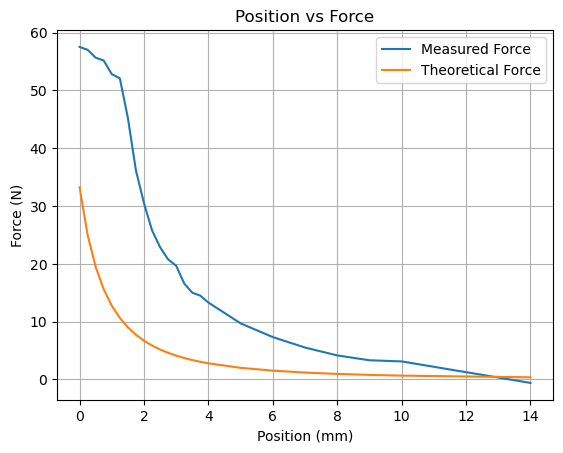

In [75]:
position = df.select('Position (mm/100)')/100
voltage = df.select('electromagnetic force')
theo_voltage = df.select('electromagnetic force from model')

fig, ax = plt.subplots()
ax.plot(position, voltage, label='Measured Force')
ax.plot(position, theo_voltage, label = 'Theoretical Force')
ax.set_title("Position vs Force")
ax.set_ylabel("Force (N)")
ax.set_xlabel("Position (mm)")
ax.legend()
plt.grid()

In [79]:
df_d = pl.DataFrame(sheet_read[1])

df_d = df_d.with_columns(
    (pl.col("load cell voltage") * conversion_coefficient).alias("total measured force"),
    (k1 * (pl.col("solenoid current") ** 2) / (0.001 + k2) ** 2 / 2).alias("electromagnetic force from model"), 
).with_columns(
    (pl.col("total measured force") - friction_force).alias("electromagnetic force")  # Subtract friction
)
df_d = df_d.drop('electromagentic force from model')
df_d_filtered = df_d[:-6]

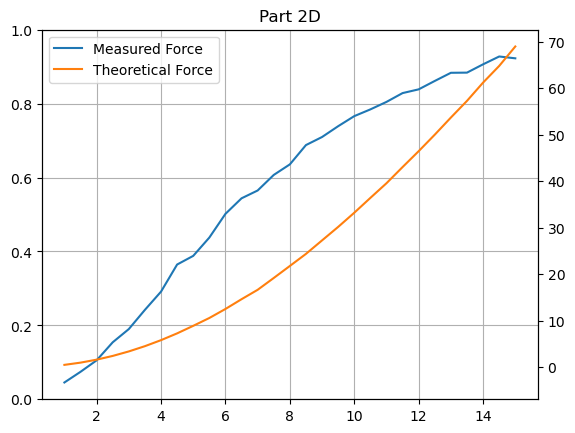

In [82]:
applied_voltage = df_d_filtered.select('Applied voltage')
current = df_d_filtered.select('solenoid current')
force = df_d_filtered.select('electromagnetic force')
theo_force = df_d_filtered.select('electromagnetic force from model')

fig, ax = plt.subplots()
# ax.plot(applied_voltage, current, label ='Measured Current', color='red')
ax2 = ax.twinx()
ax2.plot(applied_voltage, force, label='Measured Force')
ax2.plot(applied_voltage, theo_force, label='Theoretical Force')
ax.set_title('Part 2D')
ax2.legend()
ax.grid()

Text(0.5, 1.0, 'Force measurement with different pulling speed')

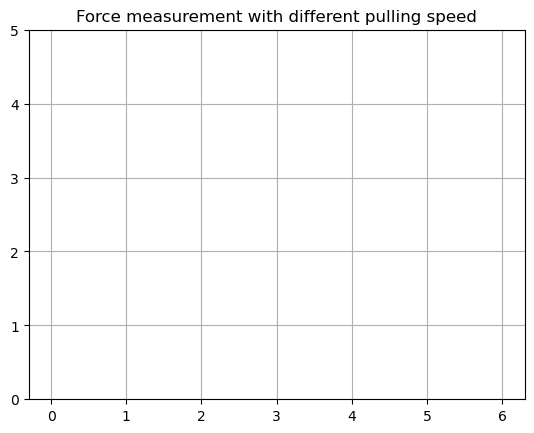

In [78]:
speed_data = df_d.filter(pl.col('Applied voltage') == 10)
speed_data

plt.plot(speed_data['electromagnetic force'])
plt.ylim(0, 5)
plt.grid()
plt.title('Force measurement with different pulling speed')